### Description: Computes GSA sensitvity indices using PCE surrogate construction using projection (Gaussian Quadrature)
#### Additional packages required: [UQTk](http://www.sandia.gov/UQToolkit/)

###### Author: Rimple Sandhu, Carleton University; Email: rimple_sandhu@outlook.com

<br> This code deals with computing Sobol sensitivity indices using PCE surrogate. The coefficeints of the PCE surrogate are computed using the projection approach. The model considered for this code is:
$$Y = a X_1 + b X_2 + c X_1 X_2$$
where the input vector is $\{X_1,X_2\}$ and parameters $a,b,c$ are some constants. The input vector has the following gaussian probability distribution:
$$\begin{Bmatrix}X_1 \\ X_2 \end{Bmatrix} \sim N \left( \begin{Bmatrix} \mu_1 \\ \mu_2 \end{Bmatrix}, \begin{bmatrix} \sigma_1^2 & 0\\ 0 & \sigma_2^2 \end{bmatrix} \right)$$
Analytical results for the SI are available:
$$Var(Y)  = a^2\sigma_1^2 + b^2\sigma_2^2 + \frac{c^2}{a^2}\mu_1^2 \sigma_2^2 + \frac{c^2}{b^2}\mu_2^2 \sigma_1^2 + c^2\sigma_1^2 \sigma_2^2 $$
$$SI_1  =  (a^2\sigma_1^2 + \frac{c^2}{b^2}\mu_2^2 \sigma_1^2)/Var(Y) $$
$$SI_2 = (b^2\sigma_2^2 + \frac{c^2}{a^2}\mu_1^2 \sigma_2^2)/Var(Y)   $$
$$SI_{12} = (c^2 \sigma_1^2 \sigma_2^2)/Var(Y)$$
Possible interesting cases to study:
- Base case: a=1,b=1,c=1; $\sigma_1^2$=1,$\sigma_2^2$=1
- Base case + b = 0.01 (sensitvity of Y to X2 is only through interaction with X1)
- Base case + c = 0.01 (Linear model, total SI = First Order SI)
- Base case + $\mu_1$ = 10.0 (Interesting!)

In [1]:
#!/usr/bin/python
from numpy import *
import matplotlib.pyplot as plt
import os
import math
import sys

Defines the function and the input distribution for the give case:

In [2]:
def Gauss2par(x):
    dim = 2
    a = 1.0
    b = 1.0
    c = 1.0
    PdfType = ['n','n']
    PdfPar =  asarray([[0,1],[0,1]])
    var1 = a**2*PdfPar[0,1]
    var2 = b**2*PdfPar[1,1]
    var12 = c**2*(PdfPar[0,1]*PdfPar[1,1]+PdfPar[0,0]**2*PdfPar[1,1]+PdfPar[1,0]**2*PdfPar[0,1])
    SI = zeros((2,dim))
    SI[0,0] = var1/(var1+var2+var12) 
    SI[0,1] = var2/(var1+var2+var12)
    SI[1,:] = SI[0,:] + var12/(var1+var2+var12)
    label = [r'$X_1$',r'$X_2$']
    if isinstance(x,int):
        return dim,PdfType,PdfPar,SI,label
    else: 
            return a*x[:,0] + b*x[:,1] + c*x[:,1]*x[:,0]

PCE Projection/Quadrature set up (UQTk quadrature type options: 'LU', 'HG', 'CC', 'CCO', 'NC', 'NCO'):

In [3]:
f  = Gauss2par # name of model (defined above)
PCtype = 'HG' # type of PC basis
p  = 2 # order of PCE expansion

In [4]:
Qtype  = 'HG' # type of quadrature
Qstype = 'full'# sparse or tensor grid
Qlvl   = 4 #level of quadrature
outLog = ' >> out.log'
set_printoptions(precision=3,suppress=True)
plotPdf =1

Extract model/parameter info and print it:

In [5]:
d,Xpdftype,Xpdfpar,SI,Xlabel = f(0)
SIest = zeros((2,d))
SIerr = zeros((2,d))
os.system('rm *.dat data/* *.pyc'+outLog)
print('Dimension : ', d)
for i in range(0,d):
    print('Parameter : ', Xlabel[i],Xpdftype[i],Xpdfpar[i,:])

Dimension :  2
Parameter :  $X_1$ n [0 1]
Parameter :  $X_2$ n [0 1]


Generate quadrature points using UQtk (outputs into a file) and load them, and then convert them into points from given nonstandard distribution:

In [6]:
CMD = 'generate_quad -g '+Qtype+' -p '+str(Qlvl)+' -d '+str(d)+' -x '+Qstype
os.system(CMD+outLog)
Xwts = loadtxt('wghts.dat')
Xpts = zeros((len(Xwts),d))
Xpts_std = loadtxt('qdpts.dat')

In [7]:
for i in range(0,d):
    if Xpdftype[i] == 'u':
        if d==1:
            Xpts[:,i] = 0.5*(Xpdfpar[i,0] + Xpdfpar[i,1]) + 0.5*(Xpdfpar[i,1] - Xpdfpar[i,0])*Xpts_std
        else:
            Xpts[:,i] = 0.5*(Xpdfpar[i,0] + Xpdfpar[i,1]) + 0.5*(Xpdfpar[i,1] - Xpdfpar[i,0])*Xpts_std[:,i]
    elif Xpdftype[i] == 'n':
        Xpts[:,i] = Xpdfpar[i,0] + sqrt(Xpdfpar[i,1])*Xpts_std[:,i]
Yvals = f(Xpts)
savetxt('ydata.dat',Yvals)

Computes PCE coefficients, read then from file, compute L2 norm, and print the results:

In [8]:
CMD = 'pce_resp -e -x '+PCtype+' -d'+str(d)+' -o'+str(p)
os.system(CMD+outLog)
PCcoeff = loadtxt('PCcoeff_quad.dat')
PCmindex = loadtxt('mindex.dat')
Ypc =loadtxt('ydata_pc.dat')
L2norm = linalg.norm(multiply(sqrt(Xwts),Yvals - Ypc),2)
PCtermsNZ = sum(1 for i in PCcoeff if abs(i) > 1e-05)

In [9]:
print('PCE type   : ',PCtype,'\nPCE Dim    : ',d,'\nPCE Order  : ',p,'\n# PCE terms: ',len(PCcoeff))
print('-------------------')
print('Quad type  : ',Qtype,'\nSparse grd?: ',Qstype,'\nQuad Level : ',Qlvl,'\n#  qpoints : ',Xpts.shape[0])
print('-------------------')
print('Non-zero PCE coeffs: (',PCtermsNZ,'/', len(PCcoeff),')')
for i,mi in enumerate(PCmindex):
    if abs(PCcoeff[i]) > 1e-05:
        print('{:5d}'.format(i),' : ', mi.astype(int),' : ', '{:8.3f}'.format(PCcoeff[i]))
print('-------------------')
print('L2 Error   : ', L2norm)
os.system('mv ydata.dat ydata_qdpts.dat')
os.system('mv ydata_pc.dat ydata_qdpts_pc.dat');

PCE type   :  HG 
PCE Dim    :  2 
PCE Order  :  2 
# PCE terms:  6
-------------------
Quad type  :  HG 
Sparse grd?:  full 
Quad Level :  4 
#  qpoints :  16
-------------------
Non-zero PCE coeffs: ( 3 / 6 )
    1  :  [1 0]  :     1.000
    2  :  [0 1]  :     1.000
    4  :  [1 1]  :     1.000
-------------------
L2 Error   :  3.231571866052598e-15


Compute sensitvity indices using PCE coefficients and print the estimated vs analytical SI values:

In [10]:
if d > 1:
    CMD = 'pce_sens -m mindex.dat -f PCcoeff_quad.dat -x'+PCtype
    os.system(CMD+outLog)
    SIest[0,:] = loadtxt('mainsens.dat')
    SIest[1,:] = loadtxt('totsens.dat')
    for i in range(0,d):
        for ii in range(0,2):
            if SI[ii,i] > 1e-02: 
                SIerr[ii,i] = 100*abs(SIest[ii,i] - SI[ii,i])/SI[ii,i]
            else:
                SIerr[ii,i] = 0.0 
    print('\nS_i  (Ex.): ', SI[0,:],'\nS_Ti (Ex.): ', SI[1,:])
    print('S_i  (PCE): ', SIest[0,:],'\nS_Ti (PCE): ', SIest[1,:])
    print('S_i (err%): ', SIerr[0,:],'\nS_Ti(err%): ', SIerr[1,:])


S_i  (Ex.):  [0.333 0.333] 
S_Ti (Ex.):  [0.667 0.667]
S_i  (PCE):  [0.333 0.333] 
S_Ti (PCE):  [0.667 0.667]
S_i (err%):  [0. 0.] 
S_Ti(err%):  [0. 0.]


Plotting the true vs PCE surrogate pdf of the output Y, this checks for goodness of PCE surrogate, along with L2 error above:  

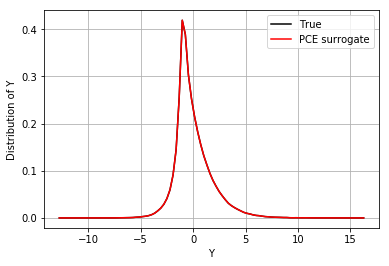

In [11]:
if plotPdf == 1:
    M = 100000
    Xspls = zeros((M,d))
    Xspls_std = zeros((M,d))
    for i in range(0,d):
        RndSeed = 100+i
        if (Xpdftype[i] == 'u'):
            CMD1 = 'trdSpls -a -1 -b 1 -n '+str(M)+' -i '+str(RndSeed)+' -f spls.dat -t u'
            os.system(CMD1)
            Xstd = loadtxt('spls.dat')
            Xnew = 0.5*(Xpdfpar[i,0] + Xpdfpar[i,1]) + 0.5*(Xpdfpar[i,1] - Xpdfpar[i,0])*Xstd
        elif (Xpdftype[i] == 'n'):
            CMD1 = 'trdSpls -a '+str(-100000)+' -b '+str(100000) \
                    +' -m 0 -s 1 -n '+str(M)+' -i '+str(RndSeed)+' -f spls.dat  -t n'
            os.system(CMD1)
            Xstd = loadtxt('spls.dat')
            Xnew = Xpdfpar[i,0] + sqrt(Xpdfpar[i,1])*Xstd
        Xspls[:,i] = Xnew
        Xspls_std[:,i] = Xstd
    os.system('rm spls.dat')
    Ymc = f(Xspls)
    savetxt('ydata_mc.dat',Ymc)
    savetxt('xdata.dat',Xspls_std)
    CMD6 = 'pdf_cl -i ydata_mc.dat'
    os.system(CMD6)
    YmcDens = loadtxt('dens.dat')
    CMD7 = 'pce_eval -x PC_mi -f PCcoeff_quad.dat -o '+str(p)+' -s '+PCtype
    os.system(CMD7+outLog)
    os.system('mv ydata.dat ydata_mc_pc.dat')
    CMD8 = 'pdf_cl -i ydata_mc_pc.dat'
    os.system(CMD8)
    YmcpcDens = loadtxt('dens.dat')
    fig = plt.figure(3)
    plt.plot(YmcDens[:,0],YmcDens[:,1],'k-',label='True')
    plt.plot(YmcpcDens[:,0],YmcpcDens[:,1],'r-',label='PCE surrogate')
    plt.grid(True)
    plt.legend(loc='best', numpoints = 1)
    plt.ylabel('Distribution of Y')
    plt.xlabel('Y')
    plt.savefig('GSA_PCE_projection_ydens.pdf',bbox_inches='tight')